<a href="https://colab.research.google.com/github/hsieh2000/HW/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install ckiptagger
!pip install ckip_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.2 MB/s eta 0:00:00


In [15]:
import os
import re
import numpy as np
import pandas as pd
from collections import Counter
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [6]:
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker
# Initialize drivers
print("Initializing drivers ... WS")
ws_driver = CkipWordSegmenter(model="bert-base", device=-1)
print("Initializing drivers ... POS")
pos_driver = CkipPosTagger(model="bert-base", device=-1)
print("Initializing drivers ... NER")
ner_driver = CkipNerChunker(model="bert-base", device=-1)
print("Initializing drivers ... all done")
print()

Initializing drivers ... WS
Initializing drivers ... POS


Initializing drivers ... NER


Initializing drivers ... all done



In [7]:
os.chdir("/content/drive/MyDrive/NLP")

In [8]:
ORIGINAL_DATA = pd.read_csv("data.csv")
ORIGINAL_DATA = ORIGINAL_DATA.drop(columns = ["Unnamed: 0"])
content = ORIGINAL_DATA["content"]


In [9]:
ORIGINAL_DATA

,article_title,content,message_count_all,message_count_boo,message_count_count,message_count_neutral,message_count_push
0,[狂幹] 孫運璿 vs 陳水扁,孫前院長和陳水扁的比較： 出身貧窮人家，苦讀完成學業，非經濟科班出身，任公職後，卻能為國拼出...,233,49,58,77,107
1,[無言] 國王的新衣,變調的童話：國王的新衣 他能在眾王子的爭奪戰中脫穎而出，除了自身的實力 其實也背負著全國極欲...,85,7,32,39,39
2,[吐嘈] =====沈老大在53台，婊DPP的4個影片片段=====,2006/05/17 民視新聞台 頭家來開講 婊DPP的4個clips 每一段都是切重要害的...,47,3,27,14,30
3,[大話] 笑話新聞 徐議員批馬片段,其實不只有徐議員啦 其他的人的講法 也大多都有入鏡 =================分格線...,21,1,11,8,12
4,[轉錄][囧rz]安西教練：「三井，你負責投外線！」,作者: mushishi (蟲師) 看板: joke 標題: [囧rz]安西教練：三井，你負...,150,3,134,10,137
...,...,...,...,...,...,...,...
79798,[討論] 這是第一次中央民調沒崩但地方大敗的局面嗎？,有長期看板上分享的民調就可以知道 不管總統或政院的滿意度 都沒像2006、2014或2018...,0,0,0,0,0
79799,[公告] 政治黑特板板規__20220803,第一章 總則 1.本板接受中華民國政府頒布之法律，教育部學術網路公約，以及PTT站方制定之...,0,0,0,0,0
79800,[公告] HatePolitic 發文門檻變更,選舉期間 發文門檻調到2000次 選舉過後視時機調回原次數 組務那邊也申請很久才設定好 也沒...,70,1,42,26,43
79801,[討論] 11月16日0時起不得再發布 評論相關民調,《公職人員選舉罷免法》第53條第2項規定，投票前10天起，也就是 11月16日0時起 ， 不...,39,0,13,26,13


In [10]:
# ws_results = ws_driver([content[0]])
# pos_results = pos_driver([content[0]])
# ner_results = ner_driver([content[0]])
# print(ws_results[0])
# print(pos_results[0])
# print(ner_results[0])



In [11]:
def read_stopword():
    with open("./stopwords_TW.txt", "r", encoding="utf-8") as f:
        stopword = [word.strip("\n") for word in f.readlines()]
    return stopword
stopwords = read_stopword()

def do_CKIP_WS(article):
  ws_results = ws_driver([article])
  return ws_results

def do_CKIP_POS(ws_result):
    # write your code in here
    pos = pos_driver(ws_result[0])
    all_list = []
    for sent in pos:

      all_list.append(sent)
    return all_list

def pos_filter(pos):
  for i in list(set(pos)):
    if i.startswith("N") or i.startswith("V"):
      return "Yes"
    else:
      continue

def cleaner(ws_results, pos_results, stopwords):
  word_lst = []
  for ws, pos in zip(ws_results[0], pos_results):
    in_stopwords_or_not = ws not in stopwords
    if_len_greater_than_1 = len(ws) > 1
    is_V_or_N = pos_filter(pos)
    if in_stopwords_or_not and if_len_greater_than_1 and is_V_or_N == "Yes":
      word_lst.append(ws)
    else:
      pass
  return word_lst


In [ ]:
seg_lst = []
for i in range(0,100):
  ws_results = do_CKIP_WS(content[i])
  pos_results = do_CKIP_POS(ws_results)
  word_lst = cleaner(ws_results, pos_results, stopwords)
  seg_lst.append(word_lst)


In [16]:
word_count = Counter()
for i in seg_lst:
  word = Counter(i)
  word_count+=word

In [98]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


(-0.5, 399.5, 199.5, -0.5)

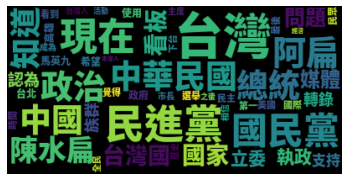

In [31]:
# -*- coding: utf-8 -*-
import nltk
from wordcloud import WordCloud
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.font_manager import fontManager
from collections import Counter

font_path = '/content/NotoSansTC-Black.otf'
wordcloud = WordCloud(max_words = 50, font_path=font_path).generate_from_frequencies(word_count)
# cloud.to_file('output.png')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [36]:
ner_lst = []
for i in range(0,100):
  ner_results = ner_driver([content[i]])
  ner_filter=['PERSON','ORG','GPE','MONEY','NORP','LOC','FAC','EVENT','PRODUCT','LAW']
  ner = [(j.word, j.ner) for j in ner_results[0] if j.ner in ner_filter]
  ner_lst.append(ner)


Inference: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


In [61]:
def NER_select(ner_lst, ner_type):
  NER_count = Counter()
  for i in ner_lst:
    for j in i:
      n = []
      if j[1] == ner_type and len(j[0]) > 1:
        n.append(j[0])

      ner_count = Counter(n)
      NER_count+=ner_count

  return NER_count

NER_count = NER_select(ner_lst, "PERSON")


(-0.5, 399.5, 199.5, -0.5)

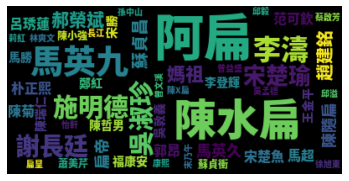

In [62]:
font_path = '/content/NotoSansTC-Black.otf'
wordcloud = WordCloud(max_words = 50, font_path=font_path).generate_from_frequencies(NER_count)
# cloud.to_file('output.png')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [63]:
NER_count

Counter({'陳水扁': 49,
         '趙建銘': 6,
         '呂游謝蘇': 1,
         '阿扁': 66,
         '鄭恩寵': 1,
         '劉駿': 1,
         '李尚平': 1,
         '柯建銘': 1,
         '文茜': 1,
         '扁皇': 2,
         '扁帝': 5,
         '台邱': 1,
         '邱溢': 2,
         '施明德': 15,
         '蔡清智': 1,
         '陳維詳': 1,
         '陳X扁': 2,
         '李X輝': 1,
         '涂醒哲': 1,
         '宋美齡': 1,
         '范可欽': 4,
         '凱達蘭': 1,
         '李濤': 18,
         '鄭弘儀': 1,
         '毛澤東': 1,
         '劉少奇': 1,
         '曹長青': 1,
         '王建民': 1,
         '陳文茜': 1,
         '蘇貞昌': 6,
         '馬英九': 26,
         '胡志強': 1,
         '謝長廷': 14,
         '趙少康': 1,
         '黃大洲': 1,
         '李遠哲': 1,
         '林義雄': 1,
         '蔡介雄': 1,
         '許添財': 1,
         '林建隆': 1,
         '王幸男': 1,
         '張兆順': 1,
         '賴春田': 1,
         '陳哲男': 3,
         '羅勝順': 1,
         '大江': 1,
         '李登輝': 3,
         '陳石龍': 1,
         '許財利': 1,
         '媽祖': 8,
         '鄭成功': 1,
         '鄭克': 1,
         '康熙': 2